In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

x1_train = train['x1']
x2_train = train['x2']
x3_train = train['x3']
y_train = train['y']

x1_test = test['x1']
x2_test = test['x2']
x3_test = test['x3']
y_test = test['y']

In [3]:
def normalize(x):
    x_min = np.amin(x)
    x_max = np.amax(x)
    return (x - x_min) / (x_max - x_min)

x1_train = normalize(x1_train)
x2_train = normalize(x2_train)
x3_train = normalize(x3_train)
x1_test = normalize(x1_test)
x2_test = normalize(x2_test)
x3_test = normalize(x3_test)

c:\Users\hikaru\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


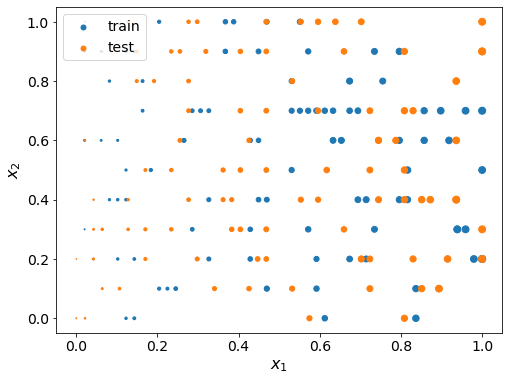

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(x1_train, x2_train, s=y_train*5, label='train')
plt.scatter(x1_test, x2_test, s=y_test*5, label='test')

plt.xlabel('$x_1$', size=16)
plt.ylabel('$x_2$', size=16)
plt.legend(loc='upper left', fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

In [5]:
def model(beta, x1, x2, x3, mask):
    y_model = beta[0] + mask[0]*beta[1]*x1 + \
        mask[1]*beta[2]*x2 + mask[2]*beta[3]*x3
    return y_model


def mse(beta, x1, x2, x3, y, mask):
    y_model = model(beta, x1, x2, x3, mask)
    mse = np.sum((y - y_model)**2) / len(y)
    return mse


beta_guess = [0, 0, 0, 0]
fit_result = minimize(mse, beta_guess, args=(
    x1_train, x2_train, x3_train, y_train, [1, 1, 1]))
sigma2 = mse(fit_result.x, x1_train, x2_train, x3_train, y_train, [1, 1, 1])
print('sigma2 = ', sigma2)


sigma2 =  0.04834879170943664


In [6]:
model_name_list = []
beta0_list = []
beta1_list = []
beta2_list = []
beta3_list = []
mse_train_list = []
mse_test_list = []
aic_list = []
bic_list = []

model_mask_list = [[0, 0, 0], [1, 0, 0], [0, 1, 0], [
    0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]]

for i in range(8):
    mask = model_mask_list[i]
    model_name = str(mask[0]) + str(mask[1]) + str(mask[2])

    beta_guess = np.array([0, 0, 0, 0])
    fit_result = minimize(mse, beta_guess, args=(
        x1_train, x2_train, x3_train, y_train, mask))

    mse_train = mse(fit_result.x, x1_train, x2_train, x3_train, y_train, mask)
    mse_test = mse(fit_result.x, x1_test, x2_test, x3_test, y_test, mask)

    n_data = len(x1_train)
    n_param = sum(mask)
    aic = (mse_train + 2*n_param*sigma2 / n_data) / sigma2
    bic = (mse_train + n_param*np.log(n_data)*sigma2 / n_data) / sigma2

    model_name_list.append(model_name)
    beta0_list.append(fit_result.x[0])
    beta1_list.append(fit_result.x[1])
    beta2_list.append(fit_result.x[2])
    beta3_list.append(fit_result.x[3])
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    aic_list.append(aic)
    bic_list.append(bic)

print('Model B0    B1    B2    B3   MSE_train MSE_teat   AIC    BIC')
fmt = "{0} {1:5.2f} {2:5.2f} {3:5.2f} {4:5.2f} {5:8.4f} {6:8.4f} {7:8.4f} {8:8.4f}"
for i in range(8):
    print(fmt.format(model_name_list[i], beta0_list[i], beta1_list[i], beta2_list[i],
          beta3_list[i], mse_train_list[i], mse_test_list[i], aic_list[i], bic_list[i]))


Model B0    B1    B2    B3   MSE_train MSE_teat   AIC    BIC
000  4.76  0.00  0.00  0.00   8.0932   8.2573 167.3927 167.3927
100  0.11  9.64  0.00  0.00   0.0490   0.0352   1.0332   1.0593
010  5.14  0.00 -0.73  0.00   8.0517   8.3499 166.5541 166.5802
001  4.96  0.00  0.00 -0.40   8.0788   8.3041 167.1133 167.1394
110  0.09  9.64  0.03  0.00   0.0489   0.0354   1.0521   1.1042
101  0.15  9.64  0.00 -0.08   0.0484   0.0357   1.0404   1.0925
011  5.41  0.00 -0.79 -0.48   8.0311   8.4185 166.1478 166.1999
111  0.14  9.64  0.02 -0.08   0.0483   0.0358   1.0600   1.1382


In [7]:
def model_ridge(beta, x1, x2, x3):
    y_model = beta[0] + beta[1]*x1 + beta[2]*x2 + beta[3]*x3
    return y_model


def ridge_loss(beta, x1, x2, x3, y, lamda):
    y_model = model_ridge(beta, x1, x2, x3)
    res = np.sum((y - y_model)**2)
    loss = res + lamda*np.sum(beta[1:]**2)
    return loss


n_lamda = 500
lamda_list = np.logspace(-2, 3, num=n_lamda)

beta0_list = []
beta1_list = []
beta2_list = []
beta3_list = []
mse_train_list = []
mse_test_list = []

for i in range(n_lamda):
    lamda = lamda_list[i]

    beta_guess = np.array([np.mean(y_train), 0, 0, 0])
    fit_result = minimize(ridge_loss, beta_guess, args=(
        x1_train, x2_train, x3_train, y_train, lamda))

    y_model_train = model_ridge(fit_result.x, x1_train, x2_train, x3_train)
    mse_train = np.sum((y_train - y_model_train)**2) / len(y_train)
    y_model_test = model_ridge(fit_result.x, x1_test, x2_test, x3_test)
    mse_test = np.sum((y_test - y_model_test)**2) / len(y_test)

    beta0_list.append(fit_result.x[0])
    beta1_list.append(fit_result.x[1])
    beta2_list.append(fit_result.x[2])
    beta3_list.append(fit_result.x[3])
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


<function matplotlib.pyplot.show(close=None, block=None)>

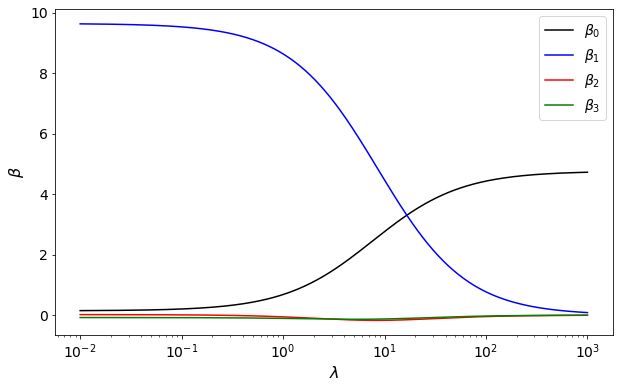

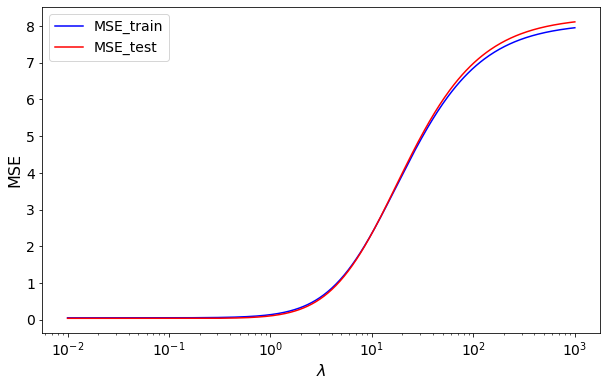

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(lamda_list, beta0_list, '-k', label=r'$\beta_0$')
plt.plot(lamda_list, beta1_list, '-b', label=r'$\beta_1$')
plt.plot(lamda_list, beta2_list, '-r', label=r'$\beta_2$')
plt.plot(lamda_list, beta3_list, '-g', label=r'$\beta_3$')
plt.xscale('log')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('$\lambda$', size=16)
plt.ylabel(r'$\beta$', size=16)
plt.tick_params(labelsize=14)
plt.show

plt.figure(figsize=(10, 6))
plt.plot(lamda_list, mse_train_list, '-b', label='MSE_train')
plt.plot(lamda_list, mse_test_list, '-r', label='MSE_test')
plt.xscale('log')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('$\lambda$', size=16)
plt.ylabel('MSE', size=16)
plt.tick_params(labelsize=14)
plt.show

In [16]:
def model_lasso(beta, x1, x2, x3):
    y_model = beta[0] + beta[1]*x1 + beta[2]*x2 + beta[3]*x3
    return y_model


def lasso_loss(beta, x1, x2, x3, y, lamda):
    y_model = model_lasso(beta, x1, x2, x3)
    res = np.sum((y - y_model)**2)
    loss = res + lamda*np.sum(np.absolute(beta[1:]))
    return loss


n_lamda = 500
lamda_list = np.logspace(-2, 3, num=n_lamda)

beta0_list = []
beta1_list = []
beta2_list = []
beta3_list = []
mse_train_list = []
mse_test_list = []

for i in range(n_lamda):
    lamda = lamda_list[i]

    beta_guess = np.array([np.mean(y_train), 0, 0, 0])
    fit_result = minimize(lasso_loss, beta_guess, args=(
        x1_train, x2_train, x3_train, y_train, lamda))

    y_model_train = model_lasso(fit_result.x, x1_train, x2_train, x3_train)
    mse_train = np.sum((y_train - y_model_train)**2) / len(y_train)
    y_model_test = model_lasso(fit_result.x, x1_test, x2_test, x3_test)
    mse_test = np.sum((y_test - y_model_test)**2) / len(y_test)

    beta0_list.append(fit_result.x[0])
    beta1_list.append(fit_result.x[1])
    beta2_list.append(fit_result.x[2])
    beta3_list.append(fit_result.x[3])
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


<function matplotlib.pyplot.show(close=None, block=None)>

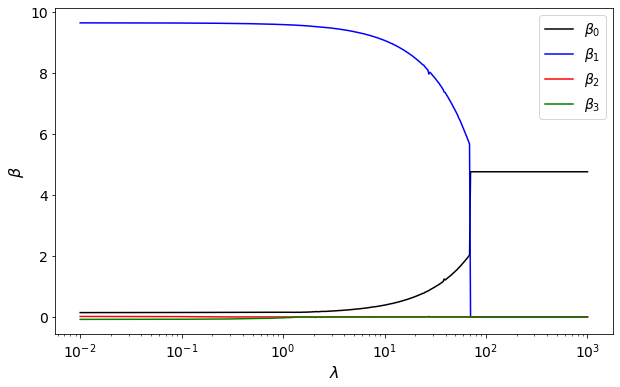

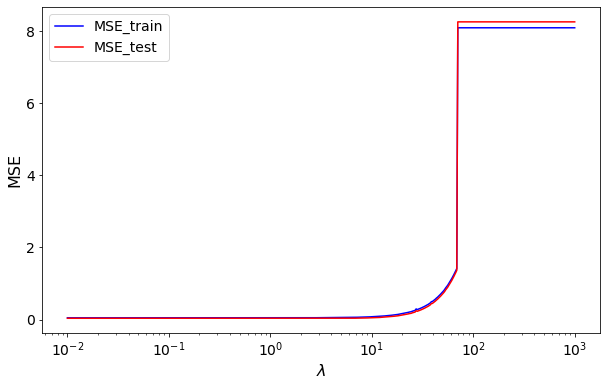

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(lamda_list, beta0_list, '-k', label=r'$\beta_0$')
plt.plot(lamda_list, beta1_list, '-b', label=r'$\beta_1$')
plt.plot(lamda_list, beta2_list, '-r', label=r'$\beta_2$')
plt.plot(lamda_list, beta3_list, '-g', label=r'$\beta_3$')
plt.xscale('log')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('$\lambda$', size=16)
plt.ylabel(r'$\beta$', size=16)
plt.tick_params(labelsize=14)
plt.show

plt.figure(figsize=(10, 6))
plt.plot(lamda_list, mse_train_list, '-b', label='MSE_train')
plt.plot(lamda_list, mse_test_list, '-r', label='MSE_test')
plt.xscale('log')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('$\lambda$', size=16)
plt.ylabel('MSE', size=16)
plt.tick_params(labelsize=14)
plt.show